<a href="https://colab.research.google.com/github/mcroning/Nonlinear-Beam-Propagation/blob/main/Cupy2mem_of_pr_coupler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
try:
  import cupy as cp
  from cupyx.scipy.ndimage import zoom, gaussian_filter
  import cupyx.scipy.fft as spfft

except:
  from scipy.ndimage import zoom, gaussian_filter
  import scipy.fft as spfft

import time
import os
import numpy as np
import random
from imageio.v2 import imread
from scipy.io import savemat,loadmat
from scipy import signal


from scipy.stats import expon
from scipy.optimize import curve_fit
import matplotlib
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image, ImageChops
from IPython import display
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ipywidgets as widgets

In [2]:
!git clone https://github.com/mcroning/Nonlinear-Beam-Propagation

Cloning into 'Nonlinear-Beam-Propagation'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 92 (delta 32), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (92/92), 9.09 MiB | 11.79 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [3]:
class res:
    def __init__(self, imout, ampxz, amp, amp0):
        self.imout = imout
        self.ampxz = ampxz
        self.amp = amp
        self.amp0=amp0

In [95]:
# @title Set Parameters { run: "auto" }
gain_length_product = -3 # @param {type:"number"}
intensity_beam_ratio_2_to_1 = 1 # @param {type:"number"}
image_on_beam = "No Image" # @param ["No Image", "Image on beam 1"]
scattering_noise_type = "none" # @param ["none", "surface"]
dark_intensity = 0.1 # @param {type:"number"}
relative_dielectric_constant = 2500 # @param {type:"number"}
mobile_charge_density = 6.4e22 # @param {type:"number"}
temperature_K = 293 # @param {type:"number"}
refractive_index = 2.4 # @param {type:"number"}
scattering_correlation_length_um = 0.6 # @param {type:"number"}
volume_noise_amplitude = 0.001 # @param {type:"number"}
surface_noise_amplitude = 0.1 # @param {type:"number"}
number_of_time_steps = 80 # @param {type:"integer"}
end_time_t0 = 8 # @param {type:"number"}
x_aperture_um = 2000 # @param {type:"number"}
y_aperture_um = 1000 # @param {type:"number"}
x_samples = "4096" # @param ["1024", "2048", "4096", "8192", "16384"]
y_samples = "256" # @param ["256", "512", "1024", "2048"]
interaction_length_um = 4000 # @param {type:"number"}
z_step_um = 100 # @param {type:"number"}
image_size_norm_by_waist1 = 1 # @param {type:"number"}
wavelength_um = 0.625 # @param {type:"number"}
beam_waist_1 = 100 # @param {type:"number"}
beam_waist_2 = 100 # @param {type:"number"}
external_angle_beam_1 = 0.16 # @param {type:"number"}
external_angle_beam_2 = -0.16 # @param {type:"number"}
azimuth_1 = 0 # @param {type:"number"}
azimuth_2 = 0 # @param {type:"number"}
Tukey_window_edge = 0.16 # @param {type:"number"}
image_type = "real image" # @param ["real image", "phase image"]
prop_random_steps = False # @param {type:"boolean"}
backpropagate_output_image = True # @param {type:"boolean"}
time_behavior = "Static" # @param ["Static", "Time Dependent"]
image_file_name = "/content/Nonlinear-Beam-Propagation/images/mnist5.png" # @param {type:"string"}
image_invert = True # @param {type:"boolean"}
fanning_study = True # @param {type:"boolean"}
warning = ""

prop_random=prop_random_steps
realimage=image_type=='phase_image'
refin=refractive_index
NT=mobile_charge_density
epsr=relative_dielectric_constant
T=temperature_K
Id=dark_intensity
gl=gain_length_product
sigma=scattering_correlation_length_um
noiseamp=volume_noise_amplitude
surfacenoise=surface_noise_amplitude
tsteps=number_of_time_steps
tend=end_time_t0
xaper=x_aperture_um
yaper=y_aperture_um
xsamp=int(x_samples)
ysamp=int(y_samples)
rlen=interaction_length_um
dz=z_step_um
image_size_factor=image_size_norm_by_waist1
lm=wavelength_um
w01=beam_waist_1
w02=beam_waist_2
thout1=external_angle_beam_1
thout2=external_angle_beam_2
phi1=azimuth_1
phi2=azimuth_2
rat=intensity_beam_ratio_2_to_1
windowedge=Tukey_window_edge
transp2=0
transp1=image_on_beam=="Image on beam 1"
noisetype=scattering_noise_type
backpropagate=backpropagate_output_image
timedep=time_behavior=="Time Dependent"
try:
  image_in=cp.ones((28,28),dtype=cp.uint8) #default image
except:
  image_in=np.ones((28,28),dtype=np.uint8) #default image

if transp1==1 and os.path.exists(image_file_name):
  image_in = Image.open(image_file_name)
  if image_invert:
    image_in=ImageChops.invert(image_in)
  plt.imshow(image_in)
  image_in = np.asarray(image_in)

  if np.ndim(image_in)==3: #color image to greyscale
      image_in=image_in.mean(axis=2)
  image_in = image_in.T  # this transposition sets 1st coordinate to x and 2nd coordinate to y
  imsizex=np.shape(image_in)[0]  #find original x dimension of image
  imsizey=np.shape(image_in)[1]  #find original y dimension
  maxsize=max(imsizex,imsizey)   #find maximum side length, maxsizenormint

  if maxsize % 2 !=0: # make sure sidees are of even length
          maxsize +=1

  image_in_sq=np.ones((maxsize,maxsize))  # make square image matrix that will hold input omage
  image_in_sq[:imsizex,:imsizey]=image_in #load potentiallly non square image ont quare image matrix
  image_in=image_in_sq.astype(np.uint16) #No
  image_in = cp.asarray(image_in)

fx1=-np.cos(phi1)*np.tan(thout1)/np.sqrt(1+(np.cos(phi1)*np.tan(thout1))**2)/lm
fy1=np.sin(phi1)*np.tan(thout1)/np.sqrt(1+(np.sin(phi1)*np.tan(thout1))**2)/lm
fx2=-np.cos(phi2)*np.tan(thout2)/np.sqrt(1+(np.cos(phi2)*np.tan(thout2))**2)/lm
fy2=np.sin(phi2)*np.tan(thout2)/np.sqrt(1+(np.sin(phi2)*np.tan(thout2))**2)/lm
fymax=ysamp/yaper/2
fxmax=xsamp/xaper/2
w1 = widgets.Output(layout={'border': '1px solid black'})
w1.clear_output()

if not(-fxmax<fx1<fxmax and -fymax<fy1<fymax):
  with w1:
    print('Warning: Beam 1 spatial frequencies became outside grid limits')

if not(-fxmax<fx2<fxmax and -fymax<fy2<fymax):
   with w1:
    print('Warning: Beam 2 spatial frequencies became outside grid limits')




prdata={
    'prop_random':prop_random,
    'realimage':realimage,
    'data_in_size':200,
    'surfacenoise':surfacenoise,
    'epsr':epsr,
    'NT':NT,
    'T':T,
    'refin': refin,
    'noiseamp': noiseamp,
    'Id':Id,
    'sigma':sigma,
    'gl': gl,
    'xaper':xaper,
    'yaper':yaper,
    'xsamp':xsamp,
    'ysamp':ysamp,
    'rlen': rlen,
    'dz' : dz,
    'windowedge':windowedge,
    'lm':lm,
    'w01':w01,
    'w02':w02,
    'thout1':thout1,
    'thout2':thout2,
    'phi1':phi2,
    'phi2':phi1,
    'rat':rat,
    'transp1':transp1,
    'transp2':transp2,
    'backpropagate':backpropagate,
    'tsteps':tsteps,
    'tend':tend,
    'timedep':timedep,
    'image_size_factor':image_size_factor,
    'production':0,
    'noisetype':noisetype
}
w1

Output(layout=Layout(border='1px solid black'))

In [96]:
dirName=os.getcwd()
niter=int(rlen/dz)
q=1.602e-19
eps0=8.854e-12
kB=1.380649e-23
x=cp.linspace(-xaper/2,xaper/2,xsamp)
y=cp.linspace(-yaper/2,yaper/2,ysamp)
z=cp.linspace(0,rlen,niter)
dx=xaper/xsamp
dy=yaper/ysamp
dX=1/xaper
dY=1/yaper
dxy=dx*dy
dXY=dX*dY
xy=xsamp*ysamp
kin=2*cp.pi*refin/lm
k0=q*cp.sqrt(NT/(epsr*eps0*kB*T))*1e-6

# no space charge field in y direction right now

#data_in_size um (size of image to be applied to beams when called for)
#data_in_size=image_size_factor*w01
#prdata['data_in_size']=int(data_in_size)

# from Garrett and Warde JOSAB 9 1407 1992
# photorefractive characteristic grating wavenumber

# characteristic space charge field (See CG whole beam method paper)

fx=cp.fft.fftfreq(xsamp,xaper/xsamp)
fy=cp.fft.fftfreq(ysamp,yaper/ysamp)
fxy=cp.zeros((xsamp,ysamp),dtype="float")
fxa=cp.tile(fx,(len(fy),1)).T
fya=cp.tile(fy,(len(fx),1))
fxy=(fxa**2+fya**2);
#calculate linear propagator
h=cp.zeros((xsamp,ysamp),dtype="complex")
h= cp.exp(2.0j*cp.pi*refin*dz/lm*cp.real(cp.sqrt(1-(lm/refin)**2*(fxy))))

##tukey window

windowx = signal.windows.tukey(xsamp,alpha=windowedge)
windowy = signal.windows.tukey(ysamp,alpha=windowedge)
windowx=cp.asarray(windowx)
windowy=cp.asarray(windowy)
windowxy=cp.outer(windowx,windowy)
fwindowxy=cp.fft.fftshift(windowxy)

#pseudorandom 3D noise array, uniform between -0.5 and 0.5

#sigma, noise correlation length microns, noiseamp amplitude of scatterers
#sigmax,y,x corresponding correlation length in terms of array units

sigmax=sigma*xsamp/xaper
sigmay=sigma*ysamp/yaper
sigmaz=sigma*niter/rlen

corrnoise1layer=cp.random.rand(xsamp,ysamp)-0.5
corrnoise1layer=gaussian_filter(corrnoise1layer,sigma=(sigmax,sigmay))
    #corrnoise=cp.random.rand(niter,xsamp,ysamp)-0.5
    #corrnoise=gaussian_filter(corrnoise,sigma=(sigmaz,sigmax,sigmay))

# define rotated coordinate systems
xp1=cp.zeros((xsamp,ysamp))
yp1=cp.zeros((xsamp,ysamp))
zp1=cp.zeros((xsamp,ysamp))
xp2=cp.zeros((xsamp,ysamp))
yp2=cp.zeros((xsamp,ysamp))
zp2=cp.zeros((xsamp,ysamp))

#empirical correction extra division by 2
el=rlen/2.0 #interaction length
th1=cp.arcsin(cp.sin(thout1)/refin)  #internal propagation angle
th2=cp.arcsin(cp.sin(thout2)/refin)
#x=xd #temp switch x to stretched

sp1=cp.sin(phi1)
cp1=cp.cos(phi1)
st1=cp.sin(th1)
ct1=cp.cos(th1)
s2p1=2*sp1*cp1
c2p1=cp1**2-sp1**2

sp2=cp.sin(phi2)
cp2=cp.cos(phi2)
st2=cp.sin(th2)
ct2=cp.cos(th2)
s2p2=2*sp2*cp2
c2p2=cp2**2-sp2**2

xa=cp.tile(x,(len(y),1)).T
ya=cp.tile(y,(len(x),1))

xp1=xa+cp1*(1-ct1)*(-xa*cp1+ya*sp1)-el*cp1*st1
yp1=ya+sp1*(1-ct1)*(xa*cp1-ya*sp1)+el*sp1*st1
zp1=(-el)*ct1+(-xa*cp1+ya*sp1)*st1
xp2=xa+cp2*(1-ct2)*(-xa*cp2+ya*sp2)-el*cp2*st2
yp2=ya+sp2*(1-ct2)*(xa*cp2-ya*sp2)+el*sp2*st2
zp2=(-el)*ct2+(-xa*cp2+ya*sp2)*st2


rotcoord=[xp1,yp1,zp1,xp2,yp2,zp2]
pr_setup=(rotcoord,h,windowxy)

In [97]:
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams["animation.html"] = "jshtml"

fig = Figure(figsize=(10, 10), dpi=100)
fig1 = Figure(figsize=(5, 5), dpi=100)
ax1 = fig.add_subplot(121)
ax4 = fig.add_subplot(122)
ax2 = fig1.add_subplot(111)
fig2 = Figure(figsize=(5, 5), dpi=100)

ax5=fig2.add_subplot(111)

fig3 = Figure(figsize=(5, 5), dpi=100)
#canvas3=FigureCanvas(self.fig3)
ax6=fig3.add_subplot(111)

# try animation
fig4 = Figure(figsize=(5, 5), dpi=100)
#canvas4 = FigureCanvas(self.fig4)
ax10=fig4.add_subplot(111)


fig5 = Figure(figsize=(5, 5), dpi=100)
#canvas5 = FigureCanvas(self.fig5)
ax11=fig5.add_subplot(111)


In [98]:
#global prdata,X_train,maxsize,image_in,geom_orig


imsizex=cp.shape(image_in)[0]  #find original x dimension of image
imsizey=cp.shape(image_in)[1]  #find original y dimension
maxsize=max(imsizex,imsizey)   #find maximum side length, maxsize
if maxsize % 2 !=0: # make sure sides are of even length
     maxsize +=1
zoomsc=prdata['image_size_factor']*prdata['w01']/maxsize # find zoom factor for image to place it on beam 1
X_train=(zoom(image_in,(zoomsc*xsamp/xaper,zoomsc*ysamp/yaper)))/cp.max(image_in) # scale input image to grid x y arrays, normalize to unity
fymax=ysamp/yaper/2

ax1.set_title('input image')
ax1.set_xlabel(r'x ($\mu$m)')
ax1.set_ylabel(r'y ($\mu$m)')
ax1.set_xlim(-yaper/4,yaper/4)
ax1.set_ylim(-yaper/4,yaper/4)
ax2.clear()
ax2.set_title('intensity cross section')
ax2.set_xlabel(r'x ($\mu$m)')
ax2.set_ylabel(r'z ($\mu$m)')
#self.ax2.set_xlim(-prdata['xaper']/2,prdata['xaper']/2)
#self.ax2.set_ylim(-prdata['yaper']/2,prdata['yaper']/2)
#self.ax2.set_ylim(prdata['rlen'],0)
ax4.set_title('output image')
ax4.set_xlabel(r'x ($\mu$m)')
ax4.set_ylabel(r'y ($\mu$m)')
ax4.set_xlim(-yaper/4,yaper/4)
ax4.set_ylim(-yaper/4,yaper/4)

(-250.0, 250.0)

In [99]:
#global prdata,pr_setup,corrnoise,X_train,ampxz,resout,imout_final,gain,ift,imin,corrnoise1layer,imout,gain_seq,t_seq,dzs,amp
#global mask1,mask2,mask1a,mask2a
#ampxz: transverse amplitude cross section (complex) [nsteps//4,xsamp,ysamp]
#resout: carries results for production version  (maybe needs only hold imout for deep learning)
#imout_final: square sample of output on beam 1 (positive frequencies) (currently size yaper/2)
#imin: input intensity matching imout_final
#gain: calculated coupling gain for two beam coupling
#ift: far field intensity (float) [nsteps,xsamp,ysamp]
#corrnoise: 3D noise array for optical scattering (not in use)
#corrnoise1layer: 2D noise array for surface scattering
#prdata: dictionary containing variables and parameters
#pr_setup: tuple containing rotcoord rotated coordinates for beam angle, h optical propagator for uniform material, w Tukey window

rotcoord=pr_setup[0]
h=pr_setup[1]
windowxy=pr_setup[2]
#import warnings
#warnings.filterwarnings("error")
arrin=X_train/cp.max(abs(X_train))
def image(x,y,arrin,prdata):
    xmin=-prdata['w01']*prdata['image_size_factor']/2
    xsamp=prdata['xsamp']
    ysamp=prdata['ysamp']
    xmax=-xmin
    ymin=xmin  #square image
    ymax=xmax  #square image
    xmag=cp.abs(x[:,0]) #x is striped in y, so x lives in first coordinate of x array
    ymag=cp.abs(y[0,:]) #y is striped in x, so y lives in second coordinate of y array
    xcenter=cp.argmin(xmag) #find where x = 0, beam transverse center
    ycenter=cp.argmin(ymag) #find where x = 0, beam transverse center
    jxs,jys=cp.shape(arrin)
    arrin_n=arrin/cp.max(arrin) #normalize image

    arrinz=zoom(arrin,(xsamp*xmax*2/xaper/jxs,ysamp*ymax*2/yaper/jys)) #zoom image to size xmax*xmax microns
    jxsz,jysz=cp.shape(arrinz)
    aout=cp.ones((xsamp,ysamp)) # default transparent uniform image covering full field
    #xb,xu,yb,yu upper and lower indices of zoomed image in full tranparency
    xb=int((xsamp-jxsz)/2)
    xu=xb+jxsz
    yb=int((ysamp-jysz)/2)
    yu=yb+jysz

    aout[xb:xu,yb:yu]=arrinz #place image at center of full field
    aout=cp.roll(aout,-xsamp//2+xcenter,axis=0) #roll image to be centered on beam 1 center
    aout=cp.roll(aout,-ysamp//2+ycenter,axis=1) #roll image to be centered on beam 1 center

    return aout

def gaus(x,y,z,beam,arrin,prdata,w0x,w0y):
    #x,y,z rotated coordinates, beam = beam number 1 or 2
    arrin=arrin/(cp.max(arrin))  #assuming real transparency for now
    lm=prdata['lm']
    rlen=prdata['rlen']
    refin=prdata['refin']
    refin=prdata['refin']
    xsamp=prdata['xsamp']
    ysamp=prdata['ysamp']
    xaper=prdata['xaper']
    yaper=prdata['yaper']

    dx=xaper/xsamp
    dy=yaper/ysamp
    thout1=prdata['thout1']
    thout2=prdata['thout2']
    th1=cp.arcsin(cp.sin(thout1)/refin)
    th2=cp.arcsin(cp.sin(thout2)/refin)
    phi1=prdata['phi1']
    phi2=prdata['phi2']
    #x1=rlen*cp.tan(th1)/2*cp.cos(phi1) #twice the axis rotationaxis z location from mathematica
    #y1=rlen*cp.tan(th1)*cp.sin(phi1)
    kout=2*cp.pi/lm
    kin=refin*kout
    z0x=w0x**2*kin/2.0
    z0y=w0y**2*kin/2.0
    eta=(cp.arctan(z/z0x)+cp.arctan(z/z0y))/2
    rlxinv=z/(z**2+z0x**2)
    rlyinv=z/(z**2+z0y**2)
    rlxinvmn=rlen/(rlen**2+z0x**2) #mean radius of curvature
    wl2x=w0x**2*(1.0+(z/z0x)**2)
    wl2y=w0y**2*(1.0+(z/z0y)**2)
    wlxy=cp.sqrt((1.0+(z/z0x)**2)*(1.0+(z/z0y)**2))
    xmax=cp.pi/(kin*dx*rlxinvmn)
    amp1 = cp.zeros((xsamp,ysamp),dtype='complex')
    argx = ((x)**2)*(1.0/wl2x-1j*kin*rlxinv/2.0)
    argy = (y**2)*(1.0/wl2y-1j*kin*rlyinv/2.0)
    arg=argx+argy
    amp1 = cp.exp(-arg+1j*kin*z-1j*eta)/cp.sqrt(wlxy)
    transp1=prdata['transp1']
    transp2=prdata['transp2']

    phasetransp=prdata['realimage']  #apply data as phase transparency if false
    # beam may have the data transparency imposed
    #apply image on beam 1
    applytransp=transp1==1

    if applytransp and not phasetransp and beam==1:
        amp1=amp1*image(x,y,arrin,prdata)
    elif applytransp and phasetransp and beam==1:
        amp1=amp1*cp.exp(2j*cp.pi*image(x,y,arrin,prdata))
    return amp1

def a(arrin,prdata,offset,rotcoord):
    #offset True then shift z by delta z for derivative d/dz calc
    rat=prdata['rat']
    a1r=1.0/cp.sqrt(1.0+rat)
    a2r=cp.sqrt(rat)/cp.sqrt(1.0+rat)

    xp1=rotcoord[0]
    yp1=rotcoord[1]
    zp1=rotcoord[2]
    xp2=rotcoord[3]
    yp2=rotcoord[4]
    zp2=rotcoord[5]
    transp1=prdata['transp1']
    transp2=prdata['transp2']
    w0x1=prdata['w01']
    w0y1=prdata['w01']
    w0x2=prdata['w02']
    w0y2=prdata['w02']

    if offset==False:
        amp1=gaus(xp1,yp1,zp1,1,arrin,prdata,w0x1,w0y1)
        amp2=gaus(xp2,yp2,zp2,2,arrin,prdata,w0x2,w0y2)
    else: #unused, for fdbpm
        amp1=gaus(xp1dz,yp1dz,zp1dz,transp1,arrin,prdata,w0x1,w0y1)
        amp2=gaus(xp2dz,yp2dz,zp2dz,transp2,arrin,prdata,w0x2,w0y2)

    atot=a1r*amp1+a2r*amp2
    print(a1r,a2r)
    print(rat)
    return atot


In [100]:

#start main propagation
#tracemalloc.start()

kout=2*cp.pi/lm      #external wavenumber
kin=refin*kout

##fx=cp.fft.fftfreq(xsamp,xaper/xsamp)
fxx=cp.tile(fx,(ysamp,1)).T  #tiled x frequencies

th1=cp.arcsin(cp.sin(thout1)/refin)
th2=cp.arcsin(cp.sin(thout2)/refin)

q=1.602e-19
eps0=8.854e-12
kB=1.380649e-23

k0=q*cp.sqrt(NT/(epsr*eps0*kB*T))*1e-6 #characteristic photorefractive wavenumber
Es=q*NT/(epsr*eps0*k0*1e6)             #characteristic space charge field
th1=cp.arcsin(cp.sin(thout1)/refin)
th2=cp.arcsin(cp.sin(thout2)/refin)
alpha=0

##niter=int(rlen/dz)

dx=xaper/xsamp
dy=yaper/ysamp
##xp1=rotcoord[0]
##yp1=rotcoord[1]
##zp1=rotcoord[2]
##xp2=rotcoord[3]
##yp2=rotcoord[4]
##zp2=rotcoord[5]

xmag1=cp.abs(xp1[:,0]) #x is striped in y, so x lives in first coordinate of x array
ymag1=cp.abs(yp1[0,:]) #y is striped in x, so y lives in second coordinate of y array
x1=(cp.argmin(xmag1)-xsamp//2)*dx #find where x = 0, beam transverse center
y1=(cp.argmin(ymag1)-ysamp//2)*dy #find where x = 0, beam transverse center

xmag2=cp.abs(xp2[:,0]) #x is striped in y, so x lives in first coordinate of x array
ymag2=cp.abs(yp2[0,:]) #y is striped in x, so y lives in second coordinate of y array
x2=(cp.argmin(xmag2)-xsamp//2)*dx #find where x = 0, beam transverse center
y2=(cp.argmin(ymag2)-ysamp//2)*dy #find where x = 0, beam transverse center
x1a=rlen*cp.tan(th1)/2*cp.cos(phi1) #twice the axis rotationaxis z location from mathematica
y1a=-rlen*cp.tan(th1)/2*cp.sin(phi1)
#image on beam 1 appears at output at -x1
x2a=rlen*cp.tan(th2)/2*cp.cos(phi2) #twice the axis rotationaxis z location from mathematica
y2a=-rlen*cp.tan(th2)/2*cp.sin(phi2)
#image on beam 2 appears at output at -x2
amp0=cp.zeros((xsamp,ysamp),dtype="complex")
ampp=cp.zeros((xsamp,ysamp),dtype="complex")
ampm=cp.zeros((xsamp,ysamp),dtype="complex")
fx1=-np.cos(phi1)*np.tan(thout1)/np.sqrt(1+(np.cos(phi1)*np.tan(thout1))**2)/lm
fy1=np.sin(phi1)*np.tan(thout1)/np.sqrt(1+(np.sin(phi1)*np.tan(thout1))**2)/lm
fx2=-np.cos(phi2)*np.tan(thout2)/np.sqrt(1+(np.cos(phi2)*np.tan(thout2))**2)/lm
fy2=np.sin(phi2)*np.tan(thout2)/np.sqrt(1+(np.sin(phi2)*np.tan(thout2))**2)/lm
#fx1np=cp.asnumpy(fx1)
#fx2np=cp.asnumpy(fx2)
#fy1np=cp.asnumpy(fy1)
#fy2np=cp.asnumpy(fy2)
mask1=np.zeros((xsamp,ysamp))
mask2=np.zeros((xsamp,ysamp))

for j in range(ysamp):
    fyj=(j-ysamp//2)/yaper
    for k in range(xsamp):
        fxk=(k-xsamp//2)/xaper
        Df1=(fxk-fx1)**2+(fyj-fy1)**2
        Df2=(fxk-fx2)**2+(fyj-fy2)**2

        if Df1<=Df2:
            mask1[k,j]=1
        else:
            mask2[k,j]=1
mask1=cp.asarray(mask1)
mask2=cp.asarray(mask2)
mask1=cp.fft.fftshift(mask1)
mask2=cp.fft.fftshift(mask2)

amp0=a(arrin,prdata,False,rotcoord)
print('ratout',rat,prdata['rat'])
amp0p=cp.fft.ifft2(cp.fft.fft2(amp0)*mask2)  #positive spatial frequency input field (beam 2 spatial frequencies)
amp0m=cp.fft.ifft2(cp.fft.fft2(amp0)*mask1)  #negative spatial frequency input field
ip0r=cp.sum(abs(amp0p)**2)  #input beam 2 intensity
im0r=cp.sum(abs(amp0m)**2)  #input beam 1 intensity
xl=(xsamp/2*(1-yaper/xaper/2)) #xl(ow), xh(igh), x indices for square sample of output
xh=(xsamp/2*(1+yaper/xaper/2))
yl=int(ysamp/2*(1-1/2)) # take half output in y extent
yh=int(ysamp/2*(1+1/2))
imcenter0=abs(amp0m[int(xl+x1/dx):int(xh+x1/dx),int(yl+y1/dy):int(yh+y1/dy)])**2 #big sample of negative frequencies (beam 1)
lx,ly=cp.shape(imcenter0)
imin=imcenter0 #imin : image in
amp=amp0*1.0  #working optical amplitude

#for speed generate noise in program, not from corrnoise stored in prdata
#rng=cp.random.default_rng(seed=3931) #fix seed 53
####corrnoise=cp.zeros((xsamp,ysamp)) @restore full correlated noise 7/5
#sigma=prdata['sigma']
#sigmax=sigma/dx
#sigmay=sigma/dy

##tsteps=prdata['tsteps'] #number of time steps
##tend=prdata['tend'] # end time
kt=0  #nonlinearity proportional to intensity to model temperature
batchsize=20
niter=int(niter//batchsize*batchsize)
batches=niter//batchsize  #niter divisible by 20
### ampft=cp.zeros((tsteps,xsamp,ysamp),dtype=complex) DEL
if timedep:
  escsfull=cp.zeros((batchsize,xsamp,ysamp),dtype=float)   #full 3D space charge field
  escsprev=cp.zeros((batchsize,xsamp,ysamp),dtype=float)
  escsp=cp.zeros((xsamp,ysamp),dtype=float)      #full space charge x gradient
  escspp=cp.zeros((xsamp,ysamp),dtype=float)     #full space charge 2nd derivative
  Delta=cp.zeros((xsamp,ysamp),dtype=float)      #change in space charge field over one time step
####corrnoise=rng.random((xsamp,ysamp))-0.5 #deleted 7/5
####corrnoise=gaussian_filter(corrnoise,sigma=(sigmax,sigmay))  # deleted 7/5
fwindowxy=cp.fft.fftshift(windowxy) #Tukey window for FT
eflag=0
errout=0
errind=cp.zeros(2)

##timedep=prdata['timedep']

deltat=0.0
if timedep==True:
    ##tsteps=prdata['tsteps']
    tsteps=4*tsteps//4

    ##tend=prdata['tend']
    deltat=tend/tsteps

    t_seq=cp.linspace(deltat,tend,tsteps)
    escsxz=cp.zeros((tsteps//4,niter,xsamp))
    ampout=cp.zeros((tsteps//4,xsamp,ysamp),dtype=complex)
    ampxz=cp.zeros((tsteps//4,niter,xsamp),dtype=complex)
else:
    tsteps=1
    escsxz=cp.zeros((1,niter,xsamp))
    ampout=cp.zeros((1,xsamp,ysamp),dtype=complex)
    ampxz=cp.zeros((1,niter,xsamp),dtype=complex)
gain_seq=cp.zeros(tsteps)
#x1=prdata['rlen']*cp.tan(th1)/2
#image on beam 1 appears at output at -x1
#x2=prdata['rlen']*cp.tan(th2)/2
backpropagate=prdata['backpropagate']
#Step over time in jt

#generate exponentially distributed propagation steps
dzs=expon.rvs(scale=dz, size=niter)
dzs=cp.asarray(dzs)
dzs=dzs/cp.sum(dzs)*rlen
#generate sum of squares of x and y frequencies for use in proagators h2 for the propagation steps
#fx=cp.fft.fftfreq(xsamp,xaper/xsamp)
#fy=cp.fft.fftfreq(ysamp,yaper/ysamp)
fxy=cp.zeros((xsamp,ysamp),dtype="float")
fxa=cp.tile(fx,(len(fy),1)).T
fya=cp.tile(fy,(len(fx),1))
fxy=(fxa**2+fya**2);


0.7071067811865475 0.7071067811865475
1
ratout 1 1


In [101]:
batch=20
for jt in range(tsteps):

        #Set input field to amp0
        amp=amp0*1.0

        #Calculate and apply surface noise
        if noisetype=='surface':
            dn= 1+prdata['surfacenoise']*corrnoise1layer #0.1 too much 3removed 7/5  one layer  no indexing [0]
            amp=amp*cp.exp(1.0j*2*cp.pi*dn)
        #begin z propagation
        tic=time.perf_counter()
        for j in range(batches):
          if j!=0:
            data=np.load(dirName+'/grating'+str(j-1)+'.npz')
            escsfull=data['arr_0']
            escsprev=data['arr_1']
#### begin batch
          for i in range(batchsize):
              if prop_random:
                  h2=cp.exp(2.0j*cp.pi*refin*dzs[j*batchsize+i]/lm*cp.real(cp.emath.sqrt(1-(lm/refin)**2*(fxy))))
                  amp=spfft.fft2(amp)*h2*fwindowxy # fwindowxy
              else:
                  # Uniform prop function here one dz step
                  amp=spfft.fft2(amp)*h*fwindowxy # fwindowxy
              # Uniform prop function here one dz step

              amp=spfft.ifft2(amp)
              # Calculate intensity
              intens2=abs(amp)**2
              # Calculate derivative of intensity
              Ip=cp.real(spfft.ifft(1.0j*2*cp.pi*fxx*spfft.fft(intens2,axis=0),axis=0))/k0
              if timedep:
                escft=spfft.fft(escsfull[i,:],axis=0)
                # Calculate transverse derivative of space charge field from previous step
                escsp=cp.real(spfft.ifft((2j*cp.pi*fxx/k0)* escft ,axis=0))
                # Calculate second derivative of space charge field from previous step
                escspp=cp.real(spfft.ifft((2j*cp.pi*fxx/k0)**2* escft ,axis=0))


                # Calculate change Delta in Esc using previous esc and current intensity
                try:
                    Delta=-((escsfull[i,:]*(intens2+Id)-Ip)*(1+escsp)-escspp*(intens2+Id))
                except:

                    if eflag ==0:

                        errout=res(escsfull, intens2, escsp[i-1,:], escspp[i-1,:])
                        errind[0]=i
                        errind[1]=jt
                    eflag=1
                    Delta=intens2*0

                #update space charge field
                escsprev[i,:]=escsfull[i,:]*1.0
                if jt ==0:
                    escsfull[i,:]= escsfull[i,:]+deltat*Delta
                else:
                    escsfull[i,:]= escsfull[i,:]*4/3 - escsprev[i,:]/3 + deltat*Delta
                dn= -escsfull[i,:]*gl/(rlen*kout) #photorefractive index array
              else:
                # Space charge field from steady state PR theory
                escs=-cp.real(spfft.ifft(-spfft.fft(Ip/(intens2+Id),axis=0)/(1+(2.0*cp.pi*fxx/k0)**2),axis=0) )
                dn= -escs*gl/(rlen*kout) #photorefractive index array

              #disable volume noise
              #if noisetype=='volume':
              #   dn=dn+noiseamp*corrnoise[i]+kt*intens2    #kt a thermal contribution
              #apply appropriate photorefractive phase change
              if prop_random:
                  amp=amp*cp.exp(1.0j*kin*dn*dzs[i])*windowxy
              else:
                  amp=amp*cp.exp(1.0j*kin*dn*dz)*windowxy

              if jt%4==0:
                  ampxz[jt//4,j*batchsize+i,:]=amp[:,ysamp//2]  #store every 4th cross section and amplitude

 ###end batch
        if timedep:
            np.savez_compressed(dirName+'/grating'+str(j)+'.npz',escsfull,escsprev)
        ampft=spfft.fft2(amp)
        ampp=spfft.ifft2(ampft*mask2)  #beam 2 intensity
        ampm=spfft.ifft2(ampft*mask1)  #beam 1 intensity
        imr=cp.sum(cp.sum(abs(ampm)**2)) # beam 2 total power
        ipr=cp.sum(cp.sum(abs(ampp)**2)) # beam 1 total power


        gain_seq[jt]=-cp.log(imr/im0r/(ipr/ip0r)) /2
        if jt%4==0:
            #ampxz[jt//4,j*batchsize+i,:]=amp[:,ysamp//2]  #store every 4th cross section and amplitude
            ampout[jt//4]=amp # store every fourth time dependent amplitude



        #end z step loop code at time step jt

        toc=time.perf_counter()
        cycle_time=toc-tic

        #ampp=cp.fft.ifft2(cp.fft.fft2(amp)*mask2) #positive freqiency beam 2
        #ampm=cp.fft.ifft2(cp.fft.fft2(amp)*mask1) #negative frequency beam 1
        iftstep=abs(cp.fft.fftshift(spfft.fft2(amp)))**2  #far field

        #ipr=cp.sum(abs(ampp)**2)
        #imr=cp.sum(abs(ampm)**2)
        gain=-cp.log(imr/im0r/(ipr/ip0r))/2
        #imcenter=abs(ampm[int(xl-x1/dx):int(xh-x1/dx),yl:yh])**2 #big sample beam 1
        imcenter=abs(ampm[int(xl-x1/dx):int(xh-x1/dx),int(yl-y1/dy):int(yh-y1/dy)])**2 #big sample of negative frequencies (beam 1)
        #imcenter0=abs(amp0m[int(xl+x1/dx):int(xh+x1/dx),int(yl+y1/dy):int(yh+y1/dy)])**2 #big sample of negative frequencies (beam 1)
        if jt==0:
            ift=iftstep
            imout=imcenter #imout : image out
        elif jt%4==0:
            ift=cp.concatenate((ift,iftstep))
            imout=cp.concatenate((imout,imcenter))
        #back propagate to see effect on image
        if backpropagate:
            ampb=amp*1.0
            x1b=-x1
            y1b=-y1

            for i in range(niter):
                ampb=spfft.fft2(ampb)*cp.conj(h)*fwindowxy # fwindowxy
                ampb=spfft.ifft2(ampb)*windowxy
            ampbft=spfft.fft2(ampb)
            ampbp=spfft.ifft2(ampbft*mask2)  #beam 2 intensity
            ampbm=spfft.ifft2(ampbft*mask1)  #beam 1 intensity
            #ampbp=cp.fft.ifft2(cp.fft.fft2(ampb)*mask2)
            #ampbm=cp.fft.ifft2(cp.fft.fft2(ampb)*mask1)
            #imcenterb=abs(ampbm[int(xl-x1b/dx):int(xh-x1b/dx),yl:yh])**2 #big sample not p
            imcenterb=abs(ampbm[int(xl-x1b/dx):int(xh-x1b/dx),int(yl-y1b/dy):int(yh-y1b/dy)])**2 #big sample of beam 1
            imcenter0=abs(amp0m[int(xl+x1/dx):int(xh+x1/dx),int(yl+y1/dy):int(yh+y1/dy)])**2 #big sample of negative frequencies (beam 1)
            if jt==0:
                imoutb=imcenterb
            elif jt%4==0:
                imoutb=cp.concatenate((imoutb,imcenterb))

#End t step loop


if prdata['timedep']==True:
    imout=cp.reshape(imout,(jt//4+1,lx,ly))
    imout=zoom(imout,(1,yaper/xaper,1)) #zoom image arrays so they appear square
    ift=cp.reshape(ift,(jt//4+1,xsamp,ysamp))
else:
    imout=cp.reshape(imout,(1,lx,ly))
    imout=zoom(imout,(1,yaper/xaper,1))
    ift=cp.reshape(ift,(1,xsamp,ysamp))

#imout, ampxz, amp, amp0i
#ixz=abs(ampxz[-1])**2


if backpropagate:
    if prdata['timedep']==True:
        imoutb=cp.reshape(imoutb,(jt//4+1,lx,ly))
        imout=zoom(imoutb,(1,yaper/xaper,1))
    else:
        imoutb=cp.reshape(imoutb,(1,lx,ly))
        imout=zoom(imoutb,(1,yaper/xaper,1))

imin=zoom(imin,(yaper/xaper,1))
resout=res(imout, ampxz, amp, amp0)  #for imout measurement
#production=False
#if production:
    #return imout
#else:
    #return resout


In [102]:
def func(xx, aa, bb): #exponential gain fit
    return aa * np.exp(-bb * xx) - aa
imoutg=imout.get()
ampxzg=ampxz.get()
iming=imin.get()
iftg=ift.get()
#x=np.linspace(-xaper/2,xaper/2,xsamp)

##niter=int(rlen/dz)
lxf=iftg.shape[1]
if timedep==0:
    tsteps=1
lbf=int(lxf*(1-xaper/yaper*ysamp/xsamp)/2) #assuming yaper<xaper
luf=int(lxf*(1+xaper/yaper*ysamp/xsamp)/2)

zs=np.zeros(niter)
zs[0]=0
for i in range(1,niter):
 zs[i]=zs[i-1]+dzs[i].get()
z=np.linspace(0,rlen,niter)
ixz=abs(ampxzg)**2

if prdata['prop_random']:

 #for i in range(tsteps//4)
    for i in range(np.shape(ixz)[0]):
         for j in range(xsamp):
            ixz[i,:,j]=np.interp(z.get(),zs,ixz[i,:,j])
maskmid=int(-xaper*(np.sin(thout1)+np.sin(thout2))/(2*lm))+xsamp//2
#mask1=cp.zeros((xsamp,ysamp))  #10/5/23
#mask2=cp.zeros((xsamp,ysamp))
#mask1[0:maskmid,:]=1
#mask2[maskmid:-1,:]=1

imout_final=imoutg[-1] #-1

imin_final=iming
#ixzf=np.abs(ampxzg[0])**2

ixzf=ixz[-1] #not [0]
u16max=65535
if prdata['timedep']==True:

    vmaxim=np.max(imoutg)
    vmaxixz=np.max(ixz)
    imoutg=imoutg/vmaxim*u16max
    imoutg=imoutg.astype(np.uint16)
    imoutTg=imoutg.T
    imoutTg=np.ascontiguousarray(imoutTg)
    ixz=ixz/vmaxixz*u16max
    ixz=ixz.astype(np.uint16)
    ax6.clear()
    line1,=ax6.plot(t_seq.get(),gain_seq.get(),label='prog output')
    popt, pcov = curve_fit(func, t_seq.get(), gain_seq.get())
    fitdata=func(t_seq.get(),popt[0],popt[1])
    line2,=ax6.plot(t_seq.get(),fitdata,label='exponential fit')
    ax6.legend(handles=[line1,line2])
    tcstr='{0:.2f}'.format(1/popt[1])
    gstr='{0:.2f}'.format(-popt[0])
    ax6.set_xlabel('time, t0 units')
    ax6.set_ylabel(r'gain $\gamma$l ')
    ax6.set_title( r'input $\gamma$l '+str(gl)+'; fit $\gamma$l ' +gstr+ '; time constant '+tcstr+ ' t0' )
    print('popt,pcov',popt,pcov)


 # try animation
    ims=[]

    ax10.clear()

    for i in range(np.shape(ixz)[0]):
        im=ax10.imshow(ixz[i],aspect='auto',vmax=u16max,extent=[-xaper/2000,xaper/2000,rlen/1000,0])
        if i ==0:
            ax10.imshow(abs(ixz[i]),aspect='auto',vmax=u16max,extent=[-xaper/2000,xaper/2000,rlen/1000,0])
            ax10.set_xlabel('x mm')
            ax10.set_ylabel('y mm')
            ax10.set_title( r'$\gamma$l '+str(prdata['gl']))
        ims.append([im])
    ani1 = animation.ArtistAnimation(fig4, ims, interval=100, blit=True,
                                    repeat_delay=1000)
    video=ani1.to_jshtml()
    html=display.HTML(video)
    display.display(html)



     #self.canvas4.draw()

    ims=[]
    ax11.clear()
     #for i in range(tsteps//4):
    for i in range(np.shape(imoutg)[0]):
         #imout spans 0.5 yaper
        ymax=yaper/1000/2/2 # in mm 1st /2 is for haly ya aperture spanning, 2nd /2 is for zero centered yaper
        im=ax11.imshow(abs(imoutg[i].T),aspect='auto',vmax=u16max,extent=[-ymax,ymax,-ymax,ymax])
        if i ==0:
            ax11.imshow(abs(imoutg[i].T),aspect='auto',vmax=u16max,extent=[-ymax,ymax,-ymax,ymax])
            ax11.set_xlabel('x mm')
            ax11.set_ylabel('y mm')
            ax11.set_title( r'$\gamma$l '+str(prdata['gl']))
        ims.append([im])
    ani2 = animation.ArtistAnimation(fig5, ims, interval=100, blit=True,
                                    repeat_delay=1000)
    video=ani2.to_jshtml()
    html=display.HTML(video)
    display.display(html)

 #self.canvas5.draw()

ax1.set_title('input image')
ax1.set_xlabel(r'x ($\mu$m)')
ax1.set_ylabel(r'y ($\mu$m)')
ax1.set_xlim(-yaper/4,yaper/4)
ax1.set_ylim(-yaper/4,yaper/4)
img=ax1.imshow(imin_final.T,extent=[-yaper/4,yaper/4,-yaper/4,yaper/4])
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(img,cax=cax)
ax2.imshow(ixzf,extent=[-xaper/2,xaper/2,prdata['rlen'],0],aspect=1)

#self.ax2.imshow(abs(amp)**2,aspect='auto')
#self.fig.tight_layout()
ax4.clear()
ax4.set_title('output image')
ax4.set_xlabel(r'x ($\mu$m)')
ax4.set_ylabel(r'y ($\mu$m)')
img=ax4.imshow(imout_final.T,extent=[-yaper/4,yaper/4,-yaper/4,yaper/4])
divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.05)

#cb=
plt.colorbar(img,cax=cax)
#cb.remove()
#self.canvas.draw()
gainstr='{0:.2f}'.format(gain)

iftf=iftg[-1] #output far field
fymax=ysamp/yaper/2
fxmax=xsamp/xaper/2
vscale=xsamp/xaper*yaper/ysamp
#fanning_mask
ws=min(w01,10)
##fx=-np.cos(phi1)*np.tan(thout1)/np.sqrt(1+(np.cos(phi1)*np.tan(thout1))**2)/lm
##fy=np.sin(phi1)*np.tan(thout1)/np.sqrt(1+(np.sin(phi1)*np.tan(thout1))**2)/lm
maskxp=int(xaper*(fx1+1/ws/2))+xsamp//2
maskxm=int(xaper*(fx1-1/ws/2))+xsamp//2
maskyp=int(yaper*(fy1+1/ws/2))+ysamp//2
maskym=int(yaper*(fy1-1/ws/2))+ysamp//2
mask=np.ones((xsamp,ysamp))
mask[maskxm:maskxp,maskym:maskyp]=0
faneff=np.sum(mask*iftf)/np.sum(iftf)
fanstr='{0:.2f}'.format(faneff)

fm=np.unravel_index(np.argmax(iftf),np.shape(iftf))

if fanning_study==True:
    ax5.clear()
    ax5.imshow((mask*iftf).T,extent=[-fxmax,fxmax,-fymax,fymax],cmap='terrain')

else:
    ax5.clear()
    ax5.imshow(iftf.T,extent=[-fxmax,fxmax,-fymax,fymax],cmap='terrain')

ax5.set_xlabel( r'x spatial frequency ($\mu m^{-1}$)')
ax5.set_ylabel( r'y freq ($\mu m^{-1}$)')
ax5.set_title( r'$\gamma$l '+str(prdata['gl']))


Text(0.5, 1.0, '$\\gamma$l -3')

<Figure size 640x480 with 0 Axes>

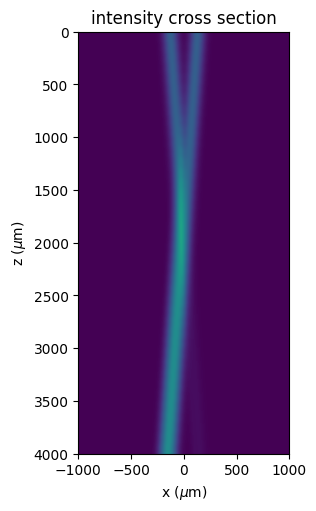

In [103]:
fig1

In [104]:
gain

array(-1.14683559)

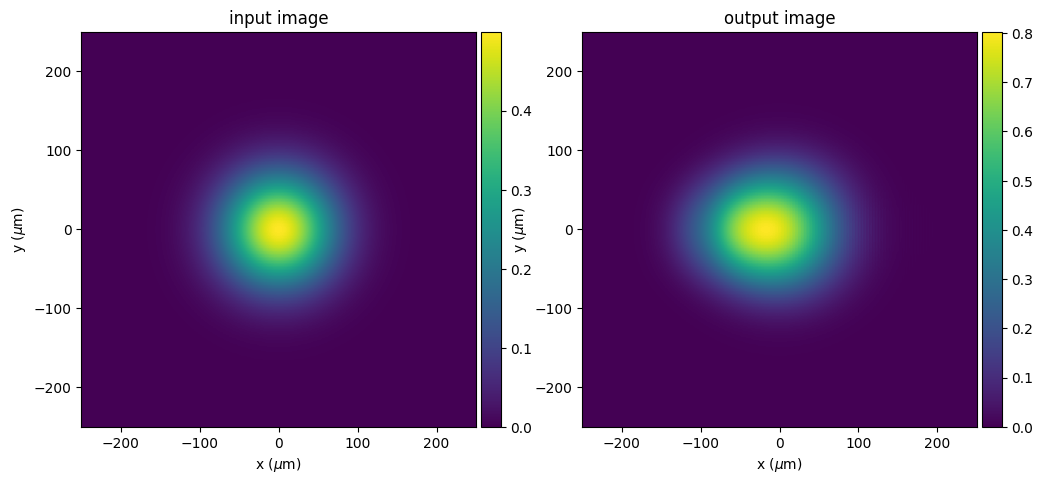

In [105]:
fig

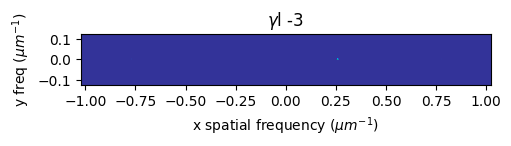

In [106]:
fig2

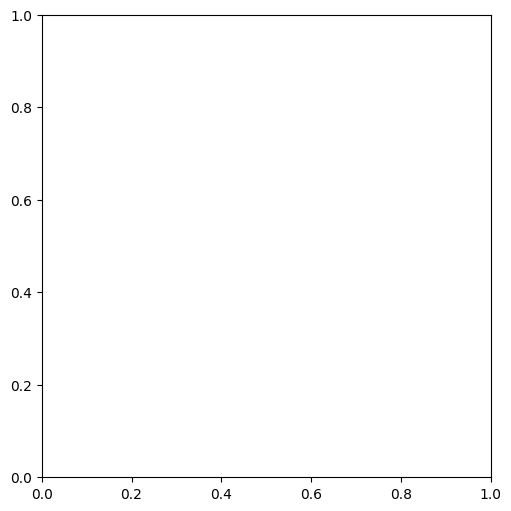

In [107]:
fig3

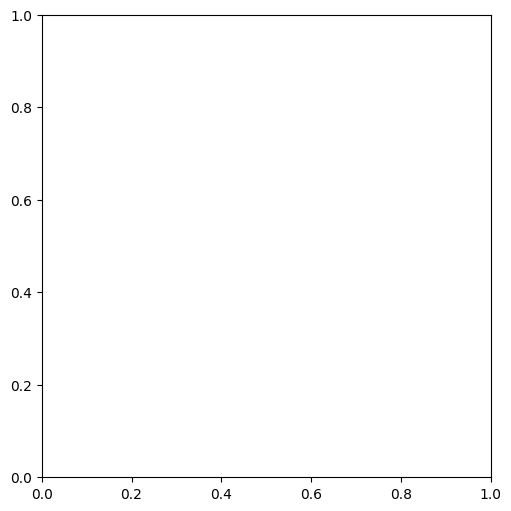

In [108]:
fig4

In [109]:
a1=np.ones(10)
a1=[0,1,2,3,4,5,6,7,8,9]
b1=np.ones(10)
b1=[0,2,4,5,6,10,12,14,16,18]

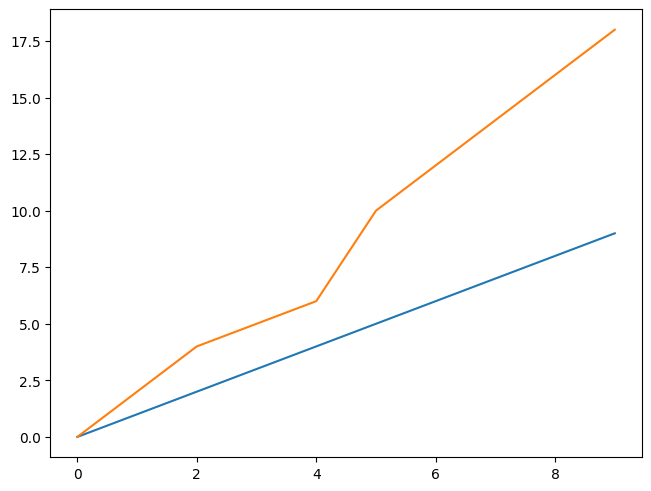

In [110]:
fig30 = plt.figure()
#canvas3=FigureCanvas(self.fig3)
ax60=fig30.add_subplot(111)
ax60.plot(a1)
ax60.plot(b1)

In [111]:
ax60.plot(a1)

In [112]:
fig30.show()